# European option pricing with ```pyop3``` continued

Author: Caden Lee (caden.finsinyur@gmail.com)

In [1]:
import numpy as np
import pyop3
import matplotlib.pyplot as plt
import scipy
from scipy import stats

## Overview
In the previous tutorial, we explored quite broadly the use of ```pyop3``` library in pricing European options, starting with setting up the underlying asset lattice by creating the ```pyop3.binomial_tree``` object. Once the underlying asset lattice is initiated, we could visualize the tree by using the ```pyop3.tree_planter.show_tree()``` function.

We then proceeded with pricing the European options. In that example, we explored pricing of European options on:
- non-dividend paying underlying asset (given a. time-to-expiry, and b. spot date and expiry date)
- Dividend paying underlying asset (known dollar dividends with ex-div coinciding expiry)
- Dividend paying underlying asset (knwon dollar dividends with ex-div before expiry)
- Underlying asset with known (dividend) yield

In this tutorial, we will be demonstrating an alternative method to deriving call and put prices, which is faster than the method shown in the past tutorial. We will also be exploring the difference between the CRR tree and the RB tree. Thereafter, we will be comparing the numerical results of the two trees to the analytical solutions from the Black-Scholes option pricing model.

## Section 1: Faster implementation to calculate European call and put option values

In tutorial 1, we demonstrated how we can derive the call option value and option tree using the ```call()``` method of the ```pyop3.european_option``` object. This methodology sets the foundation for pricing of more advanced options, such as the American options. However, this method is not essential for pricing of European options as European option does not require evaluation of every nodes in each time step. In fact, we can easily calculate the call option value by simply working on the terminal option pay off, by

$$V_{call} = e^{-rT}\sum_{i = 0}^N \big(S_0(u)^{N-i}(d)^i - K\big)\times p^{N-i}(1-p)^i   \times \bigg(\begin{matrix} N\\ i \end{matrix}\bigg)$$

where 
- $S_0$ is the spot price at time 0, 
- $K$ is the option strike price, 
- $e^{-rT}$ is the discount factor,
- $N$ is the number of time step, 
- $u$ is the upward multiplier, 
- $d$ is the downward multiplier, 
- $p$ is the risk-neutral probability of an upward movement in underlying price, and 
- $\bigg(\begin{matrix} N\\ i \end{matrix}\bigg)$ means "N choose i", which refers to the frequency of occurance of the node <i>i</i> at expiration

Once the call option value is determined, one can easily find the put option value using the put-call parity

$$C + Ke^{-rT} = P + S_0$$

Where
- $C$ is the call option value, and
- $P$ is the put option value

The fast implementation can be done by calling the ```fast_put_call()``` method of the ```pyop3.european_option``` object. Below shows the difference in execution time.

In [2]:
S0 = 300
r = 0.08
sigma = 0.3
T = 0.333

asset = pyop3.binomial_tree(S0, r, T, sigma = sigma, N = 50)
asset_options_1 = pyop3.european_option(asset, 300)
asset_options_2 = pyop3.european_option(asset.copy(), 300)

In [3]:
%%timeit

# Initialize the binomial tree object
asset_options_1.call()
asset_options_1.put()


694 µs ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
print('call: ', asset_options_1.call_value)
print('put: ', asset_options_1.put_value)

call:  24.502361910452436
put:  16.61587630625242


In [5]:
%%timeit

asset_options_2.fast_put_call()

121 µs ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
print('call: ', asset_options_2.call_value)
print('put: ', asset_options_2.put_value)

call:  24.502361910452432
put:  16.615876306250755


The fast implementation takes roughly 20% of the required time compared to running ```call()``` and ```put()``` methods separately.

## Section 2: CRR vs RB Trees

The binomial tree option pricing algorithm first introduced by Cox et al in their 1979 paper "Option Pricing: A Simplified Approach". This simplistic and elegant approach to option pricing offers the community an alternative to the Black-Scholes model, which is daunting to some in its mathematics.

The binomial option pricing algorithm generally works as it ensures weak convergence of stochastic processes and matches the first two moments of the log-returns.

The Cox-Ross-Rubinstein (CRR) Tree suggests a binomial model in which the price of the underlying asset can, at each point in time, move up by a factor of $u$ and down by a factor of $d$, which $d = \frac{1}{u}$. With these parameters, the log-tree is such that it is symmetrical about the spot price at time 0. Relating to the Black-Scholes model, we find

$$u = e^{\sigma \sqrt{T}}, d = e^{- \sigma \sqrt{T}}, p = \frac{e^{r \Delta t} - d}{u - d}$$

In the same year, Rendleman and Bartter also provided their suggestions of the Binomial tree option pricing algorithm. It looks similar to that of the CRR tree, except that it restricts the risk-neutral probability to $p = 0.5$. This means that the log-tree is no longer symmetrical about the spot price at time 0.

$$p = \frac{1}{2}, u = e^{(r-0.5\sigma^2)\Delta t + \sigma \sqrt{\Delta t}}, d = e^{(r-0.5\sigma^2)\Delta t - \sigma \sqrt{\Delta t}}$$

The RB tree has upward and downward movements similar to the discrete version of the Black-Schole model of asset price dynamic, which takes the form

$$S_{t + \Delta t} = S_0e^{(r - 0.5 \sigma^2)\Delta t + \sigma (W_{t+\Delta t} - W_t)}$$

In [7]:
asset_CRR = pyop3.binomial_tree(S0, r, T, sigma = sigma)
asset_RB = pyop3.binomial_tree(S0, r, T, sigma = sigma, tree_type= "RB")

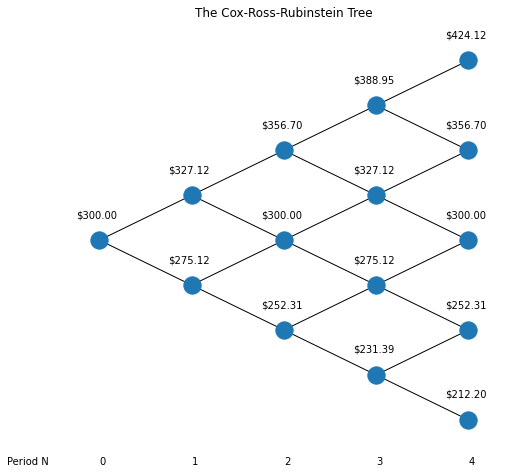

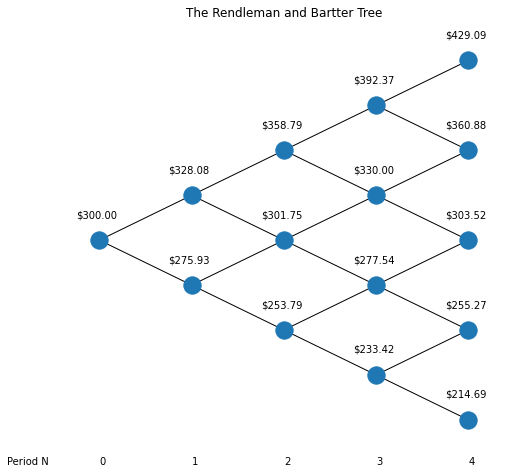

In [8]:
pyop3.tree_planter.show_tree(asset_CRR.underlying_asset_tree(), "The Cox-Ross-Rubinstein Tree")
pyop3.tree_planter.show_tree(asset_RB.underlying_asset_tree(), "The Rendleman and Bartter Tree")

In [9]:
asset_CRR_option = pyop3.european_option(asset_CRR,300)
asset_CRR_option.fast_put_call()

asset_RB_option = pyop3.european_option(asset_RB,300)
asset_RB_option.fast_put_call()

print('Call Option value based on CRR: ${:.2f}'.format(asset_CRR_option.call_value))
print('Call Option value based on RB: ${:.2f}'.format(asset_RB_option.call_value))

Call Option value based on CRR: $23.37
Call Option value based on RB: $23.96


## Section 3: Comparison Binomial Tree Models vs Black-Scholes Model

In this section, we shall evaluate the efficacy of binomial tree option pricing model in approximating the analytical solution of option prices by the Black-Scholes model.

The Option pricing equation based on the Black-Scholes model is as follows:

$$V(0,S) = S_0\Phi(d_1) - Ke^{-r(T)}\Phi(d_2)$$

where
- $d_2 = \frac{ln(\frac{S_0}{K}) + (r - \frac{1}{2}\sigma^2)(T)}{\sigma \sqrt{T}}$
- $d_1 = \frac{ln(\frac{S_0}{K}) + (r + \frac{1}{2}\sigma^2)(T)}{\sigma \sqrt{T}} = d_2 + \sigma \sqrt{T}$
- $\Phi(d_1) = \int_{-\infty}^{d_1} \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}(z - \sigma \sqrt{T})^2} dz$ is the standard cumulative distribution function
- $\Phi(d_2) = \int_{-\infty}^{d_2} \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}z^2} dz$ is the standard cumulative distribution function

In the case of a vanilla put option, where $H(T,S) = max(K - S_T,0)$, the option pricing formula is:

$$V(0,S) = Ke^{-r(T)}\Phi(-d_2) - S_0\Phi(-d_1)$$

In [10]:
# Create function to price vanilla options analytically using Black-Scholes Model
def black_scholes_option_pricer(S, K, r, T, sigma, call = True):
    '''
    Function calculates option prices based on Black-scholes model.
    Three modes available: Vanilla (default), Cash-or-Nothing (CON), Asset-or-Nothing (AON)
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: interest rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    call: default True. True if pricing call options; otherwise False

    Outputs:
    Option Prices.
    '''

    d2 = (np.log(S/K) +(r - 0.5*np.square(sigma))*(T))/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    
    d2 = d2 if call == True else -d2
    d1 = d1 if call == True else -d1
    
    option_values = S*scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return option_values

In [11]:
%%timeit

analytical_price = black_scholes_option_pricer(S0, 300, r, T, sigma)

138 µs ± 4.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
analytical_price = black_scholes_option_pricer(S0, 300, r, T, sigma)
analytical_price_arr = np.ones(100) * analytical_price

upp_limit = analytical_price_arr*1.005
low_limit = analytical_price_arr*0.995

x = np.arange(1,101,1)

Now that we have initialized our analytical solution, we shall investigate the convergence of the binomial tree models to the analytical solution. Starting from N = 1, we shall increase the time step to N = 100 and derive all the option prices with each number of time steps. We then plot the array of option prices from CRR Tree and RB Tree, and plot them against the analytical solution respectively.

In [13]:
CRR_tree_prices = np.zeros(100)
for n in x:
    asset = pyop3.binomial_tree(S0, r, T, sigma = sigma, N = int(n))
    option = pyop3.european_option(asset, 300)
    option.call()
    CRR_tree_prices[n-1] = option.call_value
    

In [14]:
RB_tree_prices = np.zeros(100)
for n in x:
    asset = pyop3.binomial_tree(S0, r, T, sigma = sigma, N = int(n), tree_type= 'RB')
    option = pyop3.european_option(asset, 300)
    option.call()
    RB_tree_prices[n-1] = option.call_value

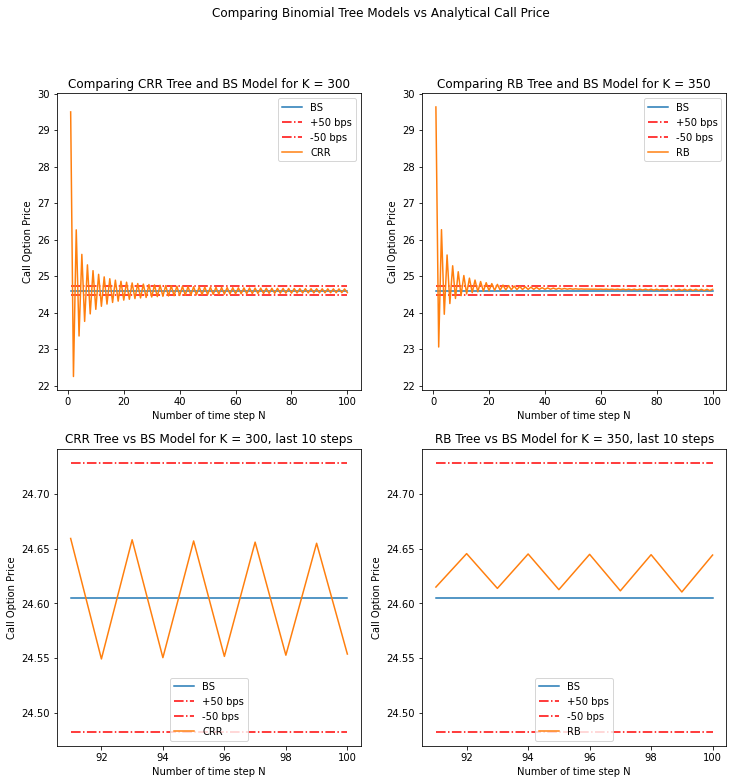

In [15]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
fig.suptitle('Comparing Binomial Tree Models vs Analytical Call Price')

# Plot CRR Tree and RB Tree against the analytical solution, from N = 1 to N = 100
ax[0,0].set_title('Comparing CRR Tree and BS Model for K = 300')
ax[0,0].plot(x, analytical_price_arr, label = 'BS')
ax[0,0].plot(x, upp_limit, label = '+50 bps', ls = '-.', c = 'r')
ax[0,0].plot(x, low_limit, label = '-50 bps', ls = '-.', c = 'r')
ax[0,0].plot(x, CRR_tree_prices, label = 'CRR')
ax[0,0].legend()

ax[0,1].set_title('Comparing RB Tree and BS Model for K = 350')
ax[0,1].plot(x, analytical_price_arr, label = 'BS')
ax[0,1].plot(x, upp_limit, label = '+50 bps', ls = '-.', c = 'r')
ax[0,1].plot(x, low_limit, label = '-50 bps', ls = '-.', c = 'r')
ax[0,1].plot(x, RB_tree_prices, label = 'RB')
ax[0,1].sharey(ax[0,0])
ax[0,1].legend()

# Plot CRR Tree and RB Tree against the analytical solution, for the last ten iterations

ax[1,0].set_title('CRR Tree vs BS Model for K = 300, last 10 steps')
ax[1,0].plot(x[-10:], analytical_price_arr[-10:], label = 'BS')
ax[1,0].plot(x[-10:], upp_limit[-10:], label = '+50 bps', ls = '-.', c = 'r')
ax[1,0].plot(x[-10:], low_limit[-10:], label = '-50 bps', ls = '-.', c = 'r')
ax[1,0].plot(x[-10:], CRR_tree_prices[-10:], label = 'CRR')
ax[1,0].legend()

ax[1,1].set_title('RB Tree vs BS Model for K = 350, last 10 steps')
ax[1,1].plot(x[-10:], analytical_price_arr[-10:], label = 'BS')
ax[1,1].plot(x[-10:], upp_limit[-10:], label = '+50 bps', ls = '-.', c = 'r')
ax[1,1].plot(x[-10:], low_limit[-10:], label = '-50 bps', ls = '-.', c = 'r')
ax[1,1].plot(x[-10:], RB_tree_prices[-10:], label = 'RB')
ax[1,1].legend()


for chart in ax.flat:
    chart.set(xlabel='Number of time step N', ylabel='Call Option Price')

plt.show()

In [16]:
np.where(np.abs(CRR_tree_prices - analytical_price) < analytical_price*0.005)

(array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
        91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),)

In [17]:
np.where(np.abs(RB_tree_prices - analytical_price) < analytical_price*0.005)

(array([11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),)

From the above results, we observed the following:
1. Results from both CRR Tree and RB Tree converges to the analytical price asymptotically
2. While the results converges, the convergence is not smooth and is accompanied by oscillations
3. For At-the-money (ATM) call options, while the results from CRR tree converges, it oscillates between prices above and below the analytical solution
4. For ATM call options, similar to the CRR Tree the results of RB tree converges; however it oscillates above the analytical price, albeit with less range
5. For ATM call options, the RB Tree converges to within 50 bps of the analytical price earlier than the CRR Tree

Results for In-the-money (ITM) and Out-of-the-money (OTM) calls may arrive at different conclusions, but all exhibit convergence with oscillations.

## Section 4: Comparing Binomial models to Analytical Solution across strikes

Now that we are comfortable with the convergence, we shall compare the results across strikes. In order to accomodate all strike levels, we set a conservative number of steps of N = 100 to ensure that our results do converge well.

In [18]:
strikes = np.arange(100,501,1)
analytical_price_per_strike = black_scholes_option_pricer(S0, strikes, r, T, sigma)

In [19]:
asset_CRR = pyop3.binomial_tree(S0, r, T, sigma = sigma, N = 100)
asset_RB = pyop3.binomial_tree(S0, r, T, sigma = sigma, N = 100, tree_type="RB")

CRR_tree_call_per_strike = np.zeros(401)
RB_tree_call_per_strike = np.zeros(401)

for i, K in enumerate(np.arange(100,501,1)):
    CRR_tree_call_per_strike[i] = pyop3.european_option(asset_CRR, K).fast_put_call()['call']
    RB_tree_call_per_strike[i] = pyop3.european_option(asset_RB, K).fast_put_call()['call']
    
log_abs_error_CRR = np.log(np.abs(CRR_tree_call_per_strike - analytical_price_per_strike))
log_abs_error_RB = np.log(np.abs(RB_tree_call_per_strike - analytical_price_per_strike))

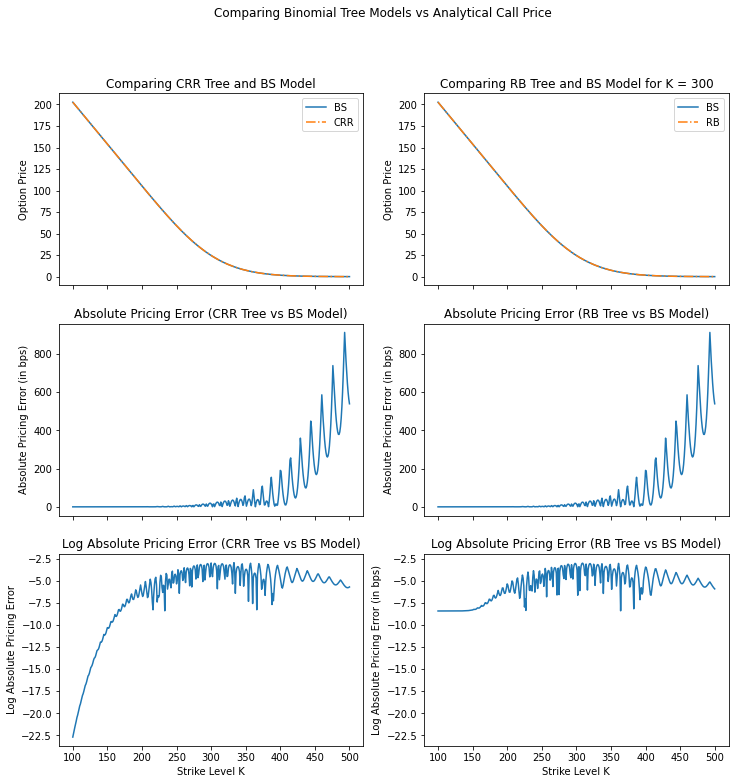

In [20]:
fig, ax = plt.subplots(3,2, figsize = (12,12), sharex = True)
fig.suptitle('Comparing Binomial Tree Models vs Analytical Call Price')

ax[0,0].set_title('Comparing CRR Tree and BS Model')
ax[0,0].plot(strikes, analytical_price_per_strike, label = 'BS')
ax[0,0].plot(strikes, CRR_tree_call_per_strike, label = 'CRR', ls = '-.')
ax[0,0].legend()
ax[0,0].set(ylabel = 'Option Price')

ax[0,1].set_title('Comparing RB Tree and BS Model for K = 300')
ax[0,1].plot(strikes, analytical_price_per_strike, label = 'BS')
ax[0,1].plot(strikes, RB_tree_call_per_strike, label = 'RB', ls = '-.')
ax[0,1].legend()
ax[0,1].set(ylabel = 'Option Price')

ax[1,0].set_title('Absolute Pricing Error (CRR Tree vs BS Model)')
ax[1,0].plot(strikes, np.abs(RB_tree_call_per_strike - analytical_price_per_strike)/analytical_price_per_strike * 100**2)
ax[1,0].set(ylabel = 'Absolute Pricing Error (in bps)')

ax[1,1].set_title('Absolute Pricing Error (RB Tree vs BS Model)')
ax[1,1].plot(strikes, np.abs(RB_tree_call_per_strike - analytical_price_per_strike)/analytical_price_per_strike * 100**2)
ax[1,1].sharey(ax[1,0])
ax[1,1].set(ylabel = 'Absolute Pricing Error (in bps)')

ax[2,0].set_title('Log Absolute Pricing Error (CRR Tree vs BS Model)')
ax[2,0].plot(strikes, log_abs_error_CRR)
ax[2,0].set(ylabel = 'Log Absolute Pricing Error', xlabel='Strike Level K')

ax[2,1].set_title('Log Absolute Pricing Error (RB Tree vs BS Model)')
ax[2,1].plot(strikes, log_abs_error_RB)
ax[2,1].sharey(ax[2,0])
ax[2,1].set(ylabel = 'Log Absolute Pricing Error (in bps)', xlabel='Strike Level K')
    
plt.show()

Generally, the binomial tree option pricing models do provide a good numerical approximation of the European option prices, however they do come with some limitations. From the above investigation, we see that the binomial tree models achieve good approximations for deep ITM options. However, as the strike level increases towards ATM and OTM levels, the relative pricing error increases significantly, to the point of explosion as we go far out-of-the-money.

The lower Absolute pricing error (in bps) is achieved for deep ITM call options as deep ITM call options tend to be very expensive. As a result, this brings the relative error low. As we move towards deep OTM call options, the lower option prices resulted in high relative error even when the absolute error remains about the same level. This is evident from the log absolute pricing error charts, where for both tree models the log absolute pricing error did not deviate too much for most of the strike levels, yet the relative error chart exploded as we go dar out-of-the-money.

From this tutorial, we can conclude that binomial tree models may not more beneficial an alternative to the analytical Black-Scholes model when it comes to computational efficiency and accuracy. Nonetheless, the binomial tree model is fairly useful as a back-of-the-envelope computation of option prices and for learners to quickly grasp the concept of option pricing. The benefits of the binomial tree option pricing model will be accentuated as we delve into more complex options, such as the American-type options which do not have an analytical solution. This will be further discussed in the next tutorials. Thank you!

© Copyright 2023, Team PyOptionTree.